In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

cleaned_path = "/content/drive/MyDrive/Major_Project/IFND_dataset/final_IFND_clean.csv"
df = pd.read_csv(cleaned_path)
print("Shape:", df.shape)
df.head()


Shape: (52754, 3)


,id,clean_text,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",True
1,3,"In Delhi, Deputy US Secretary of State Stephen...",True
2,4,LAC tensions: China's strategy behind delibera...,True
3,5,India has signed 250 documents on Space cooper...,True
4,6,Tamil Nadu chief minister's mother passes away...,True


In [ ]:
# Convert labels to uppercase (safety)
df["Label"] = df["Label"].astype(str).str.upper().str.strip()

# Count REAL and FAKE
label_counts = df["Label"].value_counts()

print(label_counts)


Label
TRUE     36450
FALSE    16304
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Use only the required columns
data = df[['id','clean_text','Label']].copy()

# 80% train, 20% temporary (for val+test)
train_df, temp_df = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['Label']
)

# Split the 20% temporary into 10% val and 10% test
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['Label']
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
train_df.to_csv("/content/drive/MyDrive/Major_Project/IFND_dataset/IFND_train.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/Major_Project/IFND_dataset/IFND_val.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/Major_Project/IFND_dataset/IFND_test.csv", index=False)

print("✅ Saved splits successfully!")


Train: (42203, 3) Val: (5275, 3) Test: (5276, 3)
✅ Saved splits successfully!


In [ ]:
import pandas as pd
base="/content/drive/MyDrive/Major_Project/IFND_dataset"
for f in ["IFND_train.csv","IFND_val.csv","IFND_test.csv"]:
    d=pd.read_csv(f"{base}/{f}")
    print(f, d['Label'].value_counts(normalize=True).round(3))

IFND_train.csv Label
True     0.691
False    0.309
Name: proportion, dtype: float64
IFND_val.csv Label
True     0.691
False    0.309
Name: proportion, dtype: float64
IFND_test.csv Label
True     0.691
False    0.309
Name: proportion, dtype: float64


In [ ]:
# 5.1 — Imports, config, paths
import os, random, numpy as np, pandas as pd, torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import torch.nn.functional as F

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Paths
BASE = "/content/drive/MyDrive/Major_Project/IFND_dataset"
TRAIN_PATH = f"{BASE}/IFND_train.csv"
VAL_PATH   = f"{BASE}/IFND_val.csv"
TEST_PATH  = f"{BASE}/IFND_test.csv"

# Labels
LABEL2ID = {"FALSE":0, "TRUE":1}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}

# Hyperparams
MODEL_NAME = "roberta-base"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15              # updated
LR = 2e-5
WARMUP_RATIO = 0.1
PATIENCE = 2             # updated

SAVE_DIR = f"{BASE}/models_roberta"
os.makedirs(SAVE_DIR, exist_ok=True)


Device: cuda


In [ ]:
# 5.2 — Load splits + encode labels + class weights
train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)

for d in [train_df, val_df, test_df]:
    d["Label"] = d["Label"].astype(str).str.upper().map(LABEL2ID)

# class weights for imbalance (~68/32)
classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=train_df["Label"].values)
class_weights = torch.tensor(cw, dtype=torch.float32).to(device)
print("Class weights [FALSE, TRUE]:", cw)
print(train_df.shape, val_df.shape, test_df.shape)

Class weights [FALSE, TRUE]: [1.61784099 0.7236454 ]
(42203, 2) (5275, 2) (5276, 2)


In [ ]:
# 5.3 — Dataset class
class TextClsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item


In [ ]:
# 5.4 — Tokenizer & Dataloaders
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = TextClsDataset(train_df["clean_text"], train_df["Label"], tokenizer, MAX_LEN)
val_ds   = TextClsDataset(val_df["clean_text"],   val_df["Label"],   tokenizer, MAX_LEN)
test_ds  = TextClsDataset(test_df["clean_text"],  test_df["Label"],  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

(2638, 330, 330)

In [ ]:
# 5.5 — Model, optimizer, scheduler, AMP scaler
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2, id2label=ID2LABEL, label2id=LABEL2ID
).to(device)

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
print("Total steps:", total_steps, "Warmup:", warmup_steps)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 39570 Warmup: 3957


/tmp/ipython-input-261240578.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


In [ ]:
# 5.6 — Eval helper (loss + macro-F1)
@torch.no_grad()
def run_eval(model, data_loader, class_weights=None):
    model.eval()
    all_preds, all_labels = [], []
    eval_loss = 0.0
    for batch in data_loader:
        batch = {k: v.to(device) for k,v in batch.items()}
        labels = batch.pop("labels")
        outputs = model(**batch)
        logits = outputs.logits
        loss = F.cross_entropy(logits, labels, weight=class_weights)
        eval_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    avg_loss = eval_loss / max(1, len(data_loader))
    f1 = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, f1, np.array(all_labels), np.array(all_preds)


In [ ]:
# 5.7 — Train loop (AMP + early stopping on macro-F1)
best_f1 = -1
wait = 0
best_path = os.path.join(SAVE_DIR, "roberta-best.pt")

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for batch in pbar:
        batch = {k: v.to(device) for k,v in batch.items()}
        labels = batch.pop("labels")

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            outputs = model(**batch)
            logits = outputs.logits
            loss = F.cross_entropy(logits, labels, weight=class_weights)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running += loss.item()
        pbar.set_postfix({"train_loss": f"{running/(pbar.n or 1):.4f}"})

    val_loss, val_f1, y_true, y_pred = run_eval(model, val_loader, class_weights)
    print(f"\nEpoch {epoch}: val_loss={val_loss:.4f} | val_macroF1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1; wait = 0
        torch.save(model.state_dict(), best_path)
        print(f"✅ New best saved → {best_path}")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("⏹️ Early stopping (no val F1 improvement).")
            break

print("Best Val macro-F1:", best_f1)


Epoch 1/15:   0%|          | 0/2638 [00:00<?, ?it/s]/tmp/ipython-input-3849056474.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
Epoch 1/15: 100%|██████████| 2638/2638 [06:12<00:00,  7.08it/s, train_loss=0.4402]



Epoch 1: val_loss=0.3124 | val_macroF1=0.9743
✅ New best saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_roberta/roberta-best.pt


Epoch 2/15:   0%|          | 0/2638 [00:00<?, ?it/s]/tmp/ipython-input-3849056474.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
Epoch 2/15: 100%|██████████| 2638/2638 [06:03<00:00,  7.25it/s, train_loss=0.2746]



Epoch 2: val_loss=0.2320 | val_macroF1=0.9736


Epoch 3/15:   0%|          | 0/2638 [00:00<?, ?it/s]/tmp/ipython-input-3849056474.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
Epoch 3/15: 100%|██████████| 2638/2638 [06:03<00:00,  7.27it/s, train_loss=0.1907]



Epoch 3: val_loss=0.2630 | val_macroF1=0.9785
✅ New best saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_roberta/roberta-best.pt


Epoch 4/15:   0%|          | 0/2638 [00:00<?, ?it/s]/tmp/ipython-input-3849056474.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
Epoch 4/15: 100%|██████████| 2638/2638 [06:04<00:00,  7.24it/s, train_loss=0.1425]



Epoch 4: val_loss=0.2478 | val_macroF1=0.9780


Epoch 5/15:   0%|          | 0/2638 [00:00<?, ?it/s]/tmp/ipython-input-3849056474.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
Epoch 5/15: 100%|██████████| 2638/2638 [06:04<00:00,  7.24it/s, train_loss=0.1191]



Epoch 5: val_loss=0.2654 | val_macroF1=0.9779
⏹️ Early stopping (no val F1 improvement).
Best Val macro-F1: 0.9785297673074497


In [ ]:
# 5.8 — Load best + test metrics
model.load_state_dict(torch.load(best_path, map_location=device))
model.to(device)

test_loss, test_f1, y_true, y_pred = run_eval(model, test_loader, class_weights)
print(f"TEST — loss: {test_loss:.4f} | macro-F1: {test_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["FALSE","TRUE"]))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


TEST — loss: 0.3010 | macro-F1: 0.9759

Classification Report:
               precision    recall  f1-score   support

       FALSE       0.98      0.95      0.97      1631
        TRUE       0.98      0.99      0.99      3645

    accuracy                           0.98      5276
   macro avg       0.98      0.97      0.98      5276
weighted avg       0.98      0.98      0.98      5276

Confusion Matrix:
 [[1555   76]
 [  32 3613]]


In [ ]:
# 5.9 — Accuracy, probabilities, ROC-AUC (Test)
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd

model.eval()
y_probs, y_true_list = [], []

with torch.no_grad():
    for batch in test_loader:
        labels_np = batch["labels"].numpy()
        y_true_list.extend(labels_np)

        batch = {k: v.to(device) for k,v in batch.items()}
        labels_t = batch.pop("labels")
        logits = model(**batch).logits
        probs = F.softmax(logits, dim=1)[:, 1]  # P(TRUE)
        y_probs.extend(probs.detach().cpu().numpy())

y_true_arr = np.array(y_true_list)
y_prob_arr = np.array(y_probs)
y_pred_arr = (y_prob_arr >= 0.5).astype(int)

test_acc = accuracy_score(y_true_arr, y_pred_arr)
test_auc = roc_auc_score(y_true_arr, y_prob_arr)

print(f"TEST Accuracy: {test_acc:.4f}")
print(f"TEST ROC-AUC : {test_auc:.4f}")

preds_df = pd.DataFrame({"y_true": y_true_arr, "y_prob_TRUE": y_prob_arr, "y_pred": y_pred_arr})
preds_path = os.path.join(SAVE_DIR, "roberta_test_predictions.csv")
preds_df.to_csv(preds_path, index=False)
print("Saved per-sample predictions →", preds_path)


TEST Accuracy: 0.9795
TEST ROC-AUC : 0.9889
Saved per-sample predictions → /content/drive/MyDrive/Major_Project/IFND_dataset/models_roberta/roberta_test_predictions.csv


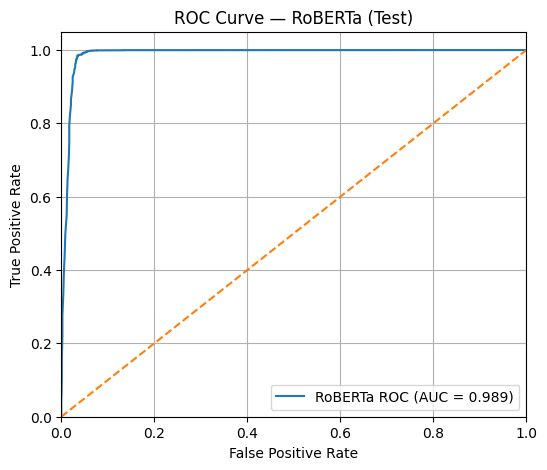

Saved ROC curve image → /content/drive/MyDrive/Major_Project/IFND_dataset/models_roberta/roberta_roc_curve.png


In [ ]:
# 5.10 — ROC Curve (plot + save)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true_arr, y_prob_arr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RoBERTa ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — RoBERTa (Test)")
plt.legend(loc="lower right"); plt.grid(True)

roc_path = os.path.join(SAVE_DIR, "roberta_roc_curve.png")
plt.savefig(roc_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved ROC curve image →", roc_path)


Generating ROC data (Test): 100%|██████████| 330/330 [00:33<00:00,  9.88it/s]


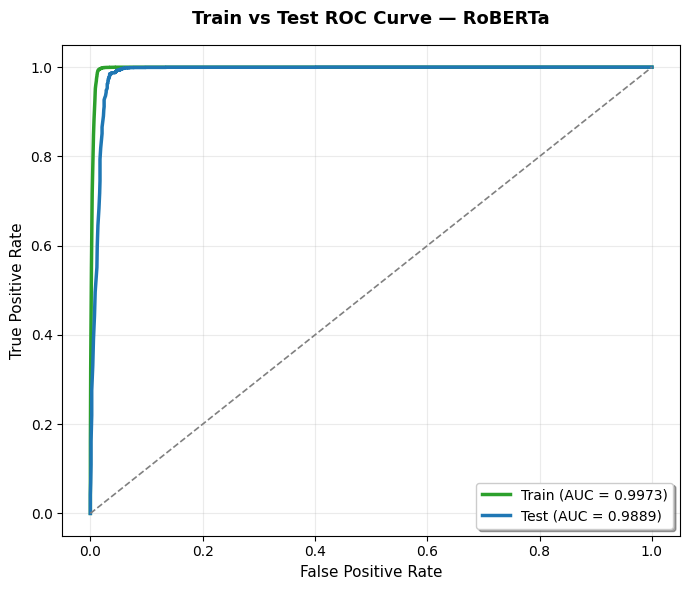

✅ Train AUC: 0.9973
✅ Test  AUC: 0.9889
🎯 Model generalizes well (no overfitting).


In [ ]:
# ============================================
# STEP 5.11 — Train vs Test ROC Curve & AUC
# ============================================
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
model.eval()

def get_roc_data(dataloader, name="Test"):
    y_true, y_scores = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Generating ROC data ({name})"):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].cpu().numpy()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
            y_true.extend(labels)
            y_scores.extend(probs)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

# ✅ Generate ROC data for both train & test
fpr_train, tpr_train, auc_train = get_roc_data(train_loader, name="Train")
fpr_test, tpr_test, auc_test = get_roc_data(test_loader, name="Test")

# ✅ Plot both ROC curves
plt.figure(figsize=(7, 6))
plt.plot(fpr_train, tpr_train, label=f"Train (AUC = {auc_train:.4f})", color="#2ca02c", lw=2.5)
plt.plot(fpr_test, tpr_test, label=f"Test (AUC = {auc_test:.4f})", color="#1f77b4", lw=2.5)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1.2)

plt.title("Train vs Test ROC Curve — RoBERTa", fontsize=13, fontweight="bold", pad=15)
plt.xlabel("False Positive Rate", fontsize=11)
plt.ylabel("True Positive Rate", fontsize=11)
plt.legend(loc="lower right", frameon=True, shadow=True)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# ✅ Print summary
print(f"✅ Train AUC: {auc_train:.4f}")
print(f"✅ Test  AUC: {auc_test:.4f}")
if abs(auc_train - auc_test) <= 0.02:
    print("🎯 Model generalizes well (no overfitting).")
elif abs(auc_train - auc_test) <= 0.05:
    print("⚠️ Slight overfitting, but acceptable.")
else:
    print("🚨 Significant overfitting detected — check regularization or data balance.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 6.1 Imports & Config (Bi-LSTM)
import os, random, numpy as np, pandas as pd, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch.nn.functional as F

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Paths
BASE = "/content/drive/MyDrive/Major_Project/IFND_dataset"
TRAIN_PATH = f"{BASE}/IFND_train.csv"
VAL_PATH   = f"{BASE}/IFND_val.csv"
TEST_PATH  = f"{BASE}/IFND_test.csv"

# Label mapping
LABEL2ID = {"FALSE":0, "TRUE":1}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}

# Save directory
SAVE_DIR = f"{BASE}/models_bilstm"
os.makedirs(SAVE_DIR, exist_ok=True)



Device: cuda


In [ ]:
# STEP 6.2 Prepare Data + Tokenization (Bi-LSTM)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)

for d in [train_df, val_df, test_df]:
    d["Label"] = d["Label"].astype(str).str.upper().map(LABEL2ID)

MAX_LEN = 128
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])
vocab_size = len(tokenizer.word_index) + 1

def encode_texts(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train = encode_texts(train_df["clean_text"])
X_val   = encode_texts(val_df["clean_text"])
X_test  = encode_texts(test_df["clean_text"])

y_train = train_df["Label"].values
y_val   = val_df["Label"].values
y_test  = test_df["Label"].values

print("Vocab size:", vocab_size)



Vocab size: 29849


In [ ]:
# STEP 6.3 Dataset Class (Bi-LSTM)
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TextDataset(X_train, y_train)
val_ds   = TextDataset(X_val, y_val)
test_ds  = TextDataset(X_test, y_test)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)



In [ ]:
# STEP 6.4 Bi-LSTM Model (Bi-LSTM)
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=128, num_layers=2, dropout=0.4):
        super().__init__()
        self.hidden_dim = hidden_dim  # ✅ store as class attribute
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        embedded = self.embedding(x)                # [batch, seq_len, embed_dim]
        lstm_out, _ = self.lstm(embedded)           # [batch, seq_len, hidden_dim*2]

        # ✅ Access using self.hidden_dim
        h_forward = lstm_out[:, -1, :self.hidden_dim]
        h_backward = lstm_out[:, 0, self.hidden_dim:]
        x = torch.cat((h_forward, h_backward), dim=1)
        logits = self.fc(x)
        return logits

model = BiLSTMClassifier(vocab_size).to(device)
print(model)



BiLSTMClassifier(
  (embedding): Embedding(29849, 256, padding_idx=0)
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
# STEP 6.5 Training Setup (Bi-LSTM)
EPOCHS = 10
LR = 1e-3
PATIENCE = 2

class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0,1]), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ✅ Fix: remove 'verbose' argument for compatibility
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)




Class weights: tensor([1.6178, 0.7236], device='cuda:0')


In [ ]:
# STEP 6.6 Evaluation Helper (Bi-LSTM)
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels, losses = [], [], []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1, np.array(all_labels), np.array(all_preds)



In [ ]:
# STEP 6.7 Training Loop (Bi-LSTM)
best_f1 = -1
wait = 0
best_path = os.path.join(SAVE_DIR, "bilstm-best.pt")

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # ✅ Gradient clipping
        optimizer.step()
        running += loss.item()

    val_loss, val_f1, _, _ = evaluate(model, val_loader)
    scheduler.step(val_f1)

    print(f"\nEpoch {epoch}: train_loss={running/len(train_loader):.4f} | val_loss={val_loss:.4f} | val_F1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1; wait = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'vocab_size': vocab_size,
            'embed_dim': 256,
            'hidden_dim': 128
        }, best_path)
        print(f"✅ New best model saved → {best_path}")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

print("Best Val F1:", best_f1)



Epoch 1/10: 100%|██████████| 660/660 [00:14<00:00, 44.36it/s]



Epoch 1: train_loss=0.2007 | val_loss=0.1540 | val_F1=0.9309
✅ New best model saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_bilstm/bilstm-best.pt


Epoch 2/10: 100%|██████████| 660/660 [00:14<00:00, 45.13it/s]



Epoch 2: train_loss=0.1125 | val_loss=0.1433 | val_F1=0.9521
✅ New best model saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_bilstm/bilstm-best.pt


Epoch 3/10: 100%|██████████| 660/660 [00:15<00:00, 43.55it/s]



Epoch 3: train_loss=0.0727 | val_loss=0.1516 | val_F1=0.9588
✅ New best model saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_bilstm/bilstm-best.pt


Epoch 4/10: 100%|██████████| 660/660 [00:15<00:00, 43.62it/s]



Epoch 4: train_loss=0.0379 | val_loss=0.1913 | val_F1=0.9402


Epoch 5/10: 100%|██████████| 660/660 [00:14<00:00, 44.56it/s]



Epoch 5: train_loss=0.0198 | val_loss=0.2272 | val_F1=0.9519
⏹️ Early stopping triggered.
Best Val F1: 0.9588037960579048


In [ ]:
# STEP 6.8 Load Best + Test Metrics (Bi-LSTM)
checkpoint = torch.load(best_path, map_location=device)
model = BiLSTMClassifier(checkpoint['vocab_size'],
                         embed_dim=checkpoint['embed_dim'],
                         hidden_dim=checkpoint['hidden_dim']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_f1, y_true, y_pred = evaluate(model, test_loader)
print(f"TEST — loss: {test_loss:.4f} | macro-F1: {test_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["FALSE","TRUE"]))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))



TEST — loss: 0.1737 | macro-F1: 0.9553

Classification Report:
               precision    recall  f1-score   support

       FALSE       0.95      0.93      0.94      1631
        TRUE       0.97      0.98      0.97      3645

    accuracy                           0.96      5276
   macro avg       0.96      0.95      0.96      5276
weighted avg       0.96      0.96      0.96      5276

Confusion Matrix:
 [[1511  120]
 [  80 3565]]


In [ ]:
# STEP 6.9 ROC-AUC + Accuracy (Bi-LSTM)
from sklearn.metrics import roc_curve, auc

model.eval()
y_true_list, y_probs = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        logits = model(X)
        probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        y_probs.extend(probs)
        y_true_list.extend(y.numpy())

y_true_arr = np.array(y_true_list)
y_prob_arr = np.array(y_probs)
y_pred_arr = (y_prob_arr >= 0.5).astype(int)

test_acc = accuracy_score(y_true_arr, y_pred_arr)
test_auc = roc_auc_score(y_true_arr, y_prob_arr)
print(f"TEST Accuracy: {test_acc:.4f}")
print(f"TEST ROC-AUC : {test_auc:.4f}")


TEST Accuracy: 0.9621
TEST ROC-AUC : 0.9794


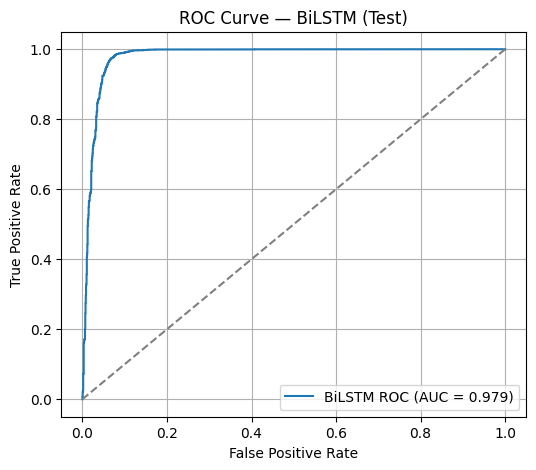

Saved ROC curve image → /content/drive/MyDrive/Major_Project/IFND_dataset/models_bilstm/bilstm_roc_curve.png


In [ ]:
# STEP 6.10 ROC Curve Plot (Bi-LSTM)
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true_arr, y_prob_arr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"BiLSTM ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — BiLSTM (Test)")
plt.legend(loc="lower right"); plt.grid(True)
roc_path = os.path.join(SAVE_DIR, "bilstm_roc_curve.png")
plt.savefig(roc_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved ROC curve image →", roc_path)



Generating ROC data (Test): 100%|██████████| 83/83 [00:00<00:00, 153.33it/s]


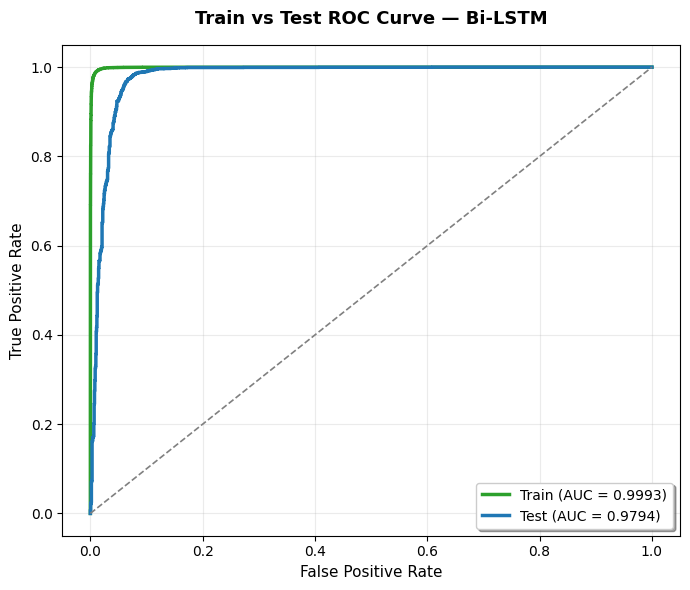

✅ Train AUC: 0.9993
✅ Test  AUC: 0.9794
🎯 Model generalizes well (no overfitting).


In [ ]:
# ============================================
# STEP 6.11 — Train vs Test ROC Curve & AUC (Bi-LSTM)
# ============================================
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
model.eval()

def get_roc_data(dataloader, name="Test"):
    y_true, y_scores = [], []
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc=f"Generating ROC data ({name})"):
            X = X.to(DEVICE)
            logits = model(X)
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # P(TRUE)
            y_true.extend(y.numpy())
            y_scores.extend(probs)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

# ✅ Generate ROC data for both train & test
fpr_train, tpr_train, auc_train = get_roc_data(train_loader, name="Train")
fpr_test, tpr_test, auc_test = get_roc_data(test_loader, name="Test")

# ✅ Plot both ROC curves
plt.figure(figsize=(7, 6))
plt.plot(fpr_train, tpr_train, label=f"Train (AUC = {auc_train:.4f})", color="#2ca02c", lw=2.5)
plt.plot(fpr_test, tpr_test, label=f"Test (AUC = {auc_test:.4f})", color="#1f77b4", lw=2.5)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1.2)

plt.title("Train vs Test ROC Curve — Bi-LSTM", fontsize=13, fontweight="bold", pad=15)
plt.xlabel("False Positive Rate", fontsize=11)
plt.ylabel("True Positive Rate", fontsize=11)
plt.legend(loc="lower right", frameon=True, shadow=True)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# ✅ Print summary
print(f"✅ Train AUC: {auc_train:.4f}")
print(f"✅ Test  AUC: {auc_test:.4f}")

if abs(auc_train - auc_test) <= 0.02:
    print("🎯 Model generalizes well (no overfitting).")
elif abs(auc_train - auc_test) <= 0.05:
    print("⚠️ Slight overfitting, but acceptable.")
else:
    print("🚨 Significant overfitting detected — check regularization or data balance.")


In [ ]:
# ============================================
# STEP 6.12 — Save Test Predictions (Bi-LSTM)
# ============================================

import pandas as pd

preds_df = pd.DataFrame({
    "y_true": y_true_arr,
    "y_prob_TRUE": y_prob_arr,
    "y_pred": y_pred_arr
})

preds_path = os.path.join(SAVE_DIR, "bilstm_test_predictions.csv")
preds_df.to_csv(preds_path, index=False)

print("✅ Saved Bi-LSTM test predictions →", preds_path)


✅ Saved Bi-LSTM test predictions → /content/drive/MyDrive/Major_Project/IFND_dataset/models_bilstm/bilstm_test_predictions.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# STEP 7.1 — Imports, config, paths (Bi-LSTM + Attn + Stacked GRU)
import os, random, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Paths
BASE = "/content/drive/MyDrive/Major_Project/IFND_dataset"
TRAIN_PATH = f"{BASE}/IFND_train.csv"
VAL_PATH   = f"{BASE}/IFND_val.csv"
TEST_PATH  = f"{BASE}/IFND_test.csv"

# Label mapping (ensure labels match)
LABEL2ID = {"FALSE":0, "TRUE":1}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}

# Save directory
SAVE_DIR = f"{BASE}/models_hybrid"
os.makedirs(SAVE_DIR, exist_ok=True)


Device: cuda


In [ ]:
# STEP 7.2 Prepare Data + Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)

# map labels (ensure uppercase)
for d in [train_df, val_df, test_df]:
    d["Label"] = d["Label"].astype(str).str.upper().map(LABEL2ID)

MAX_LEN = 128
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])
vocab_size = len(tokenizer.word_index) + 1

def encode_texts(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train = encode_texts(train_df["clean_text"])
X_val   = encode_texts(val_df["clean_text"])
X_test  = encode_texts(test_df["clean_text"])

y_train = train_df["Label"].values
y_val   = val_df["Label"].values
y_test  = test_df["Label"].values

print("Vocab size:", vocab_size)


Vocab size: 29849


In [ ]:
# 7.3 Dataset class and DataLoader
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TextDataset(X_train, y_train)
val_ds   = TextDataset(X_val, y_val)
test_ds  = TextDataset(X_test, y_test)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)


In [ ]:
# 7.4 HYBRID MODEL: Bi-LSTM + Attention + Stacked GRU

import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # input dim = 2*hidden (bidirectional)
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_outputs):
        # lstm_outputs: [batch, seq_len, 2*hidden]
        scores = self.v(torch.tanh(self.attn(lstm_outputs))).squeeze(-1)  # [batch, seq_len]
        weights = F.softmax(scores, dim=1)  # [batch, seq_len]
        weighted_output = (lstm_outputs * weights.unsqueeze(-1)).sum(dim=1)  # [batch, 2*hidden]
        return weighted_output, weights

class HybridBiLSTM_Attn_GRU(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=128,
                 num_gru_layers=1, dropout=0.3):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Bi-LSTM
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True,
                              bidirectional=True, dropout=dropout)

        # Attention
        self.attn = AttentionLayer(hidden_dim)

        # Stacked GRU (takes attn vector as seq_len=1 input)
        self.gru = nn.GRU(hidden_dim * 2, hidden_dim,
                          num_layers=num_gru_layers,
                          batch_first=True,
                          bidirectional=False,
                          dropout=dropout)

        # Classifier
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        # x: [batch, seq_len]
        x = self.embedding(x)  # [batch, seq_len, embed_dim]

        lstm_out, _ = self.bilstm(x)  # [batch, seq_len, 2*hidden]
        attn_vec, attn_weights = self.attn(lstm_out)  # attn_vec: [batch, 2*hidden]

        # make seq for GRU: [batch, 1, 2*hidden]
        gru_input = attn_vec.unsqueeze(1)
        gru_out, _ = self.gru(gru_input)  # [batch, 1, hidden]
        gru_final = gru_out[:, -1, :]     # [batch, hidden]

        logits = self.fc(gru_final)       # [batch, 2]
        return logits

# instantiate model
model = HybridBiLSTM_Attn_GRU(vocab_size, embed_dim=256, hidden_dim=128,
                             num_gru_layers=1, dropout=0.3).to(device)
print(model)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


HybridBiLSTM_Attn_GRU(
  (embedding): Embedding(29849, 256, padding_idx=0)
  (bilstm): LSTM(256, 128, batch_first=True, dropout=0.3, bidirectional=True)
  (attn): AttentionLayer(
    (attn): Linear(in_features=256, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=False)
  )
  (gru): GRU(256, 128, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
# 7.5 Training setup
EPOCHS = 15
LR = 1e-3
PATIENCE = 3

# compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0,1]), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(weight=class_weights)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=1     # ← verbose removed here
)

best_f1 = -1
wait = 0
best_path = os.path.join(SAVE_DIR, "hybrid-best.pt")


Class weights: tensor([1.6178, 0.7236], device='cuda:0')


In [ ]:
# 7.6 Evaluation helper
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels, losses = [], [], []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        losses.append(loss.item())
    avg_loss = np.mean(losses) if len(losses)>0 else 0.0
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1, np.array(all_labels), np.array(all_preds)


In [ ]:
# 7.7 Training loop
for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running += loss.item()

    train_loss = running / len(train_loader)
    val_loss, val_f1, _, _ = evaluate(model, val_loader)
    scheduler.step(val_f1)

    print(f"\nEpoch {epoch}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_F1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1; wait = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'vocab_size': vocab_size,
            'embed_dim': 256,
            'hidden_dim': 128,
            'num_gru_layers': 1
        }, best_path)
        print(f"✅ New best model saved → {best_path}")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

print("Best Val F1:", best_f1)


Epoch 1/15: 100%|██████████| 660/660 [00:09<00:00, 68.75it/s]



Epoch 1: train_loss=0.1992 | val_loss=0.1413 | val_F1=0.9557
✅ New best model saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_hybrid/hybrid-best.pt


Epoch 2/15: 100%|██████████| 660/660 [00:08<00:00, 76.99it/s]



Epoch 2: train_loss=0.1029 | val_loss=0.1362 | val_F1=0.9536


Epoch 3/15: 100%|██████████| 660/660 [00:08<00:00, 77.02it/s]



Epoch 3: train_loss=0.0505 | val_loss=0.1551 | val_F1=0.9572
✅ New best model saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_hybrid/hybrid-best.pt


Epoch 4/15: 100%|██████████| 660/660 [00:08<00:00, 76.15it/s]



Epoch 4: train_loss=0.0263 | val_loss=0.1636 | val_F1=0.9541


Epoch 5/15: 100%|██████████| 660/660 [00:14<00:00, 46.21it/s]



Epoch 5: train_loss=0.0155 | val_loss=0.2417 | val_F1=0.9504


Epoch 6/15: 100%|██████████| 660/660 [00:10<00:00, 61.09it/s]



Epoch 6: train_loss=0.0051 | val_loss=0.2469 | val_F1=0.9559
⏹️ Early stopping triggered.
Best Val F1: 0.9571638836725371


In [ ]:
# 7.8 Load best and evaluate on test
checkpoint = torch.load(best_path, map_location=device)

model = HybridBiLSTM_Attn_GRU(
    checkpoint['vocab_size'],
    embed_dim=checkpoint['embed_dim'],
    hidden_dim=checkpoint['hidden_dim'],
    num_gru_layers=1,   # 🔥 SAME as training
    dropout=0.3          # 🔥 SAME as training
).to(device)

model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_f1, y_true, y_pred = evaluate(model, test_loader)
print(f"TEST — loss: {test_loss:.4f} | macro-F1: {test_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["FALSE","TRUE"]))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


TEST — loss: 0.1776 | macro-F1: 0.9554

Classification Report:
               precision    recall  f1-score   support

       FALSE       0.95      0.92      0.94      1631
        TRUE       0.97      0.98      0.97      3645

    accuracy                           0.96      5276
   macro avg       0.96      0.95      0.96      5276
weighted avg       0.96      0.96      0.96      5276

Confusion Matrix:
 [[1504  127]
 [  72 3573]]


In [ ]:
# 7.9 ROC-AUC & accuracy on test
from sklearn.metrics import roc_curve, auc

model.eval()
y_true_list, y_probs = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        logits = model(X)
        probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()  # prob of TRUE
        y_probs.extend(probs)
        y_true_list.extend(y.numpy())

y_true_arr = np.array(y_true_list)
y_prob_arr = np.array(y_probs)
y_pred_arr = (y_prob_arr >= 0.5).astype(int)

test_acc = accuracy_score(y_true_arr, y_pred_arr)
test_auc = roc_auc_score(y_true_arr, y_prob_arr)
print(f"TEST Accuracy: {test_acc:.4f}")
print(f"TEST ROC-AUC : {test_auc:.4f}")


TEST Accuracy: 0.9623
TEST ROC-AUC : 0.9817


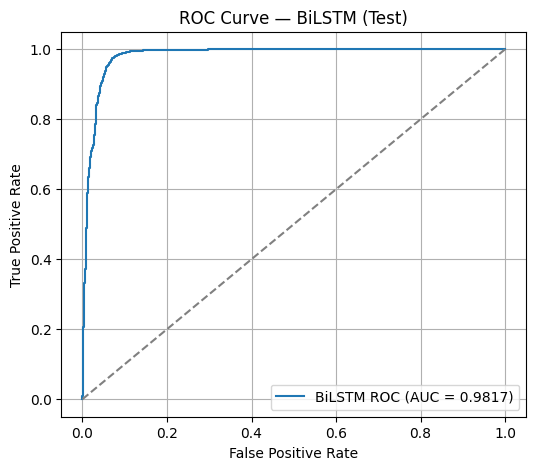

Saved ROC curve image → /content/drive/MyDrive/Major_Project/IFND_dataset/models_hybrid/bilstm_roc_curve.png


In [ ]:
# STEP 7.10 ROC Curve Plot (Bi-LSTM + attention + Stacked GRU)
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true_arr, y_prob_arr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"BiLSTM ROC (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — BiLSTM (Test)")
plt.legend(loc="lower right"); plt.grid(True)
roc_path = os.path.join(SAVE_DIR, "bilstm_roc_curve.png")
plt.savefig(roc_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved ROC curve image →", roc_path)


Generating ROC data (Test): 100%|██████████| 83/83 [00:00<00:00, 252.87it/s]


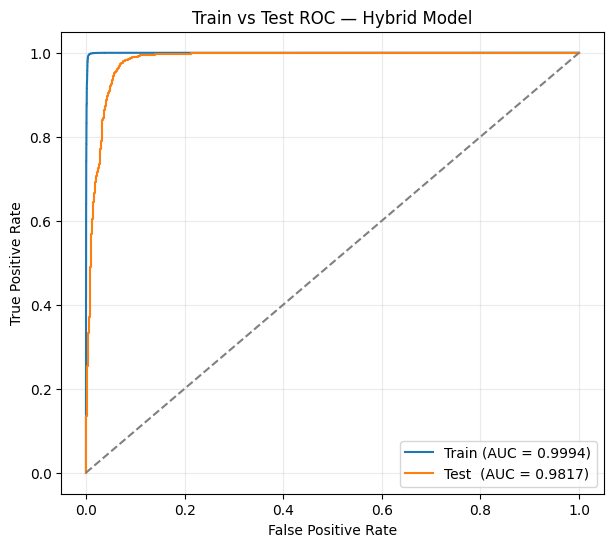

✅ Train AUC: 0.9994
✅ Test  AUC: 0.9817
🎯 Model generalizes well (no overfitting).


In [ ]:
# 7.11 Train vs Test ROC curves
def get_roc_data(dataloader, name="Test"):
    y_true, y_scores = [], []
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc=f"Generating ROC data ({name})"):
            X = X.to(device)
            logits = model(X)
            probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y_true.extend(y.numpy())
            y_scores.extend(probs)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

fpr_train, tpr_train, auc_train = get_roc_data(train_loader, name="Train")
fpr_test, tpr_test, auc_test = get_roc_data(test_loader, name="Test")

plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f"Train (AUC = {auc_train:.4f})")
plt.plot(fpr_test, tpr_test, label=f"Test  (AUC = {auc_test:.4f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Train vs Test ROC — Hybrid Model")
plt.legend(loc="lower right"); plt.grid(alpha=0.25)
plt.show()

print(f"✅ Train AUC: {auc_train:.4f}")
print(f"✅ Test  AUC: {auc_test:.4f}")

if abs(auc_train - auc_test) <= 0.02:
    print("🎯 Model generalizes well (no overfitting).")
elif abs(auc_train - auc_test) <= 0.05:
    print("⚠️ Slight overfitting, but acceptable.")
else:
    print("🚨 Significant overfitting detected — check regularization or data balance.")


In [ ]:
# 7.12 Save predictions
preds_df = pd.DataFrame({
    "y_true": y_true_arr,
    "y_prob_TRUE": y_prob_arr,
    "y_pred": y_pred_arr
})

preds_path = os.path.join(SAVE_DIR, "hybrid_test_predictions.csv")
preds_df.to_csv(preds_path, index=False)
print("✅ Saved hybrid test predictions →", preds_path)


✅ Saved hybrid test predictions → /content/drive/MyDrive/Major_Project/IFND_dataset/models_hybrid/hybrid_test_predictions.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# FUSION 1 – Imports, config, paths

import os, random, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Paths
BASE = "/content/drive/MyDrive/Major_Project/IFND_dataset"
TRAIN_PATH = f"{BASE}/IFND_train.csv"
VAL_PATH   = f"{BASE}/IFND_val.csv"
TEST_PATH  = f"{BASE}/IFND_test.csv"

ROBERTA_BEST_PATH = f"{BASE}/models_roberta/roberta-best.pt"
HYBRID_BEST_PATH  = f"{BASE}/models_hybrid/hybrid-best.pt"

# Labels mapping
LABEL2ID = {"FALSE":0, "TRUE":1}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}

# Hyperparams
ROBERTA_NAME = "roberta-base"
MAX_LEN = 128        # same as before
BATCH_SIZE_FUSION = 32
EPOCHS_FUSION = 10
PATIENCE_FUSION = 3
LR_FUSION = 1e-3

SAVE_DIR_FUSION = f"{BASE}/models_fusion"
os.makedirs(SAVE_DIR_FUSION, exist_ok=True)


Device: cuda


In [ ]:
# FUSION 2 – Load train/val/test splits & prepare Hybrid (Keras) tokenizer

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)

# map labels to IDs (same as before)
for d in [train_df, val_df, test_df]:
    d["Label"] = d["Label"].astype(str).str.upper().map(LABEL2ID)

y_train = train_df["Label"].values
y_val   = val_df["Label"].values
y_test  = test_df["Label"].values

# Keras Tokenizer for Hybrid side (same logic as your hybrid model)
keras_tokenizer = Tokenizer(oov_token="<OOV>")
keras_tokenizer.fit_on_texts(train_df["clean_text"])
vocab_size = len(keras_tokenizer.word_index) + 1
print("Vocab size (Hybrid):", vocab_size)

def encode_texts_keras(texts):
    seq = keras_tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_train_hyb = encode_texts_keras(train_df["clean_text"])
X_val_hyb   = encode_texts_keras(val_df["clean_text"])
X_test_hyb  = encode_texts_keras(test_df["clean_text"])

print("Hybrid sequences shapes:", X_train_hyb.shape, X_val_hyb.shape, X_test_hyb.shape)


Vocab size (Hybrid): 29849
Hybrid sequences shapes: (42203, 128) (5275, 128) (5276, 128)


In [ ]:
# FUSION 3 – Dataset class combining RoBERTa tokens + Hybrid sequences

roberta_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_NAME)

class FusionDataset(Dataset):
    def __init__(self, texts, labels, roberta_tok, hybrid_seqs, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.roberta_tok = roberta_tok
        self.hybrid_seqs = torch.tensor(hybrid_seqs, dtype=torch.long)
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # RoBERTa tokenization
        enc = self.roberta_tok(
            text,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in enc.items()}

        # Hybrid sequence
        item["hyb_seq"] = self.hybrid_seqs[idx]

        # Label
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_fusion_ds = FusionDataset(train_df["clean_text"], y_train, roberta_tokenizer, X_train_hyb, MAX_LEN)
val_fusion_ds   = FusionDataset(val_df["clean_text"],   y_val,   roberta_tokenizer, X_val_hyb,   MAX_LEN)
test_fusion_ds  = FusionDataset(test_df["clean_text"],  y_test,  roberta_tokenizer, X_test_hyb,  MAX_LEN)

train_fusion_loader = DataLoader(train_fusion_ds, batch_size=BATCH_SIZE_FUSION, shuffle=True)
val_fusion_loader   = DataLoader(val_fusion_ds,   batch_size=BATCH_SIZE_FUSION, shuffle=False)
test_fusion_loader  = DataLoader(test_fusion_ds,  batch_size=BATCH_SIZE_FUSION, shuffle=False)

len(train_fusion_loader), len(val_fusion_loader), len(test_fusion_loader)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

(1319, 165, 165)

In [ ]:
# FUSION 4 – Attention + HybridBiLSTM_Attn_GRU (same as before, plus encode() method)

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_outputs):
        # lstm_outputs: [batch, seq_len, 2*hidden]
        scores = self.v(torch.tanh(self.attn(lstm_outputs))).squeeze(-1)  # [batch, seq_len]
        weights = F.softmax(scores, dim=1)  # [batch, seq_len]
        weighted_output = (lstm_outputs * weights.unsqueeze(-1)).sum(dim=1)  # [batch, 2*hidden]
        return weighted_output, weights

class HybridBiLSTM_Attn_GRU(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=128,
                 num_gru_layers=1, dropout=0.3):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True,
                              bidirectional=True, dropout=dropout)

        self.attn = AttentionLayer(hidden_dim)

        self.gru = nn.GRU(hidden_dim * 2, hidden_dim,
                          num_layers=num_gru_layers,
                          batch_first=True,
                          bidirectional=False,
                          dropout=dropout)

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

    def encode(self, x):
        # x: [batch, seq_len]
        x = self.embedding(x)
        lstm_out, _ = self.bilstm(x)
        attn_vec, _ = self.attn(lstm_out)
        gru_input = attn_vec.unsqueeze(1)
        gru_out, _ = self.gru(gru_input)
        gru_final = gru_out[:, -1, :]   # [batch, hidden_dim]
        return gru_final

    def forward(self, x):
        gru_final = self.encode(x)
        logits = self.fc(gru_final)
        return logits


In [ ]:
# FUSION 5 – Load fine-tuned RoBERTa and Hybrid models

# ----- RoBERTa (classification model with hidden states) -----
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    ROBERTA_NAME,
    num_labels=2,
    id2label=ID2LABEL,
    label2id=LABEL2ID
).to(device)

roberta_state = torch.load(ROBERTA_BEST_PATH, map_location=device)
roberta_model.load_state_dict(roberta_state)
roberta_model.eval()

# Freeze RoBERTa parameters (feature extractor mode)
for p in roberta_model.parameters():
    p.requires_grad = False

# ----- Hybrid model -----
checkpoint_hyb = torch.load(HYBRID_BEST_PATH, map_location=device)

hybrid_model = HybridBiLSTM_Attn_GRU(
    vocab_size=checkpoint_hyb['vocab_size'],
    embed_dim=checkpoint_hyb['embed_dim'],
    hidden_dim=checkpoint_hyb['hidden_dim'],
    num_gru_layers=1,
    dropout=0.3
).to(device)

hybrid_model.load_state_dict(checkpoint_hyb['model_state_dict'])
hybrid_model.eval()

# Freeze Hybrid parameters (feature extractor mode)
for p in hybrid_model.parameters():
    p.requires_grad = False

print("RoBERTa & Hybrid loaded and frozen.")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa & Hybrid loaded and frozen.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [ ]:
# FUSION 6 – Fusion model (RoBERTa CLS + Hybrid GRU hidden → classifier)

class FusionModel(nn.Module):
    def __init__(self, roberta_model, hybrid_model, fusion_dropout=0.3):
        super().__init__()
        self.roberta = roberta_model
        self.hybrid  = hybrid_model

        fusion_dim = 768 + 128   # RoBERTa CLS (768) + Hybrid hidden (128)

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(fusion_dropout),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask, hyb_seq):
        # ---- RoBERTa CLS embedding ----
        with torch.no_grad():
            outputs = self.roberta(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
            cls_vec = outputs.hidden_states[-1][:, 0, :]   # [B, 768]

        # ---- Hybrid GRU embedding ----
        with torch.no_grad():
            gru_vec = self.hybrid.encode(hyb_seq)          # [B, 128]

        fused = torch.cat([cls_vec, gru_vec], dim=1)       # [B, 896]
        logits = self.classifier(fused)
        return logits

fusion_model = FusionModel(roberta_model, hybrid_model).to(device)
print(fusion_model)


FusionModel(
  (roberta): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dens

In [ ]:
# FUSION 7 – Training setup (only classifier head trainable)

# Only parameters of classifier will be updated
optimizer = torch.optim.Adam(fusion_model.classifier.parameters(), lr=LR_FUSION)
criterion = nn.CrossEntropyLoss()

best_val_f1 = -1
wait_fusion = 0
best_fusion_path = os.path.join(SAVE_DIR_FUSION, "fusion-best.pt")


In [ ]:
# FUSION 8 – Evaluation helper

@torch.no_grad()
def evaluate_fusion(model, loader):
    model.eval()
    all_preds, all_labels, losses, all_probs = [], [], [], []
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        hyb_seq = batch["hyb_seq"].to(device)
        labels  = batch["labels"].to(device)

        logits = model(input_ids, attention_mask, hyb_seq)
        loss = criterion(logits, labels)

        probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(logits, dim=1)

        all_probs.extend(probs)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        losses.append(loss.item())

    avg_loss = np.mean(losses) if len(losses) > 0 else 0.0
    f1 = f1_score(all_labels, all_preds, average="macro")
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, np.array(all_probs))

    return avg_loss, f1, acc, auc, np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [ ]:
# FUSION 9 – Training loop

for epoch in range(1, EPOCHS_FUSION + 1):
    fusion_model.train()
    running = 0.0

    pbar = tqdm(train_fusion_loader, desc=f"Fusion Epoch {epoch}/{EPOCHS_FUSION}")
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        hyb_seq = batch["hyb_seq"].to(device)
        labels  = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = fusion_model(input_ids, attention_mask, hyb_seq)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(fusion_model.classifier.parameters(), max_norm=1.0)
        optimizer.step()

        running += loss.item()
        pbar.set_postfix({"train_loss": f"{running/(pbar.n or 1):.4f}"})

    # Validation
    val_loss, val_f1, val_acc, val_auc, _, _, _ = evaluate_fusion(fusion_model, val_fusion_loader)
    print(f"\nEpoch {epoch}: val_loss={val_loss:.4f} | val_F1={val_f1:.4f} | val_acc={val_acc:.4f} | val_AUC={val_auc:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        wait_fusion = 0
        torch.save(fusion_model.state_dict(), best_fusion_path)
        print(f"✅ New best fusion model saved → {best_fusion_path}")
    else:
        wait_fusion += 1
        if wait_fusion >= PATIENCE_FUSION:
            print("⏹️ Early stopping (Fusion).")
            break

print("Best Val F1 (Fusion):", best_val_f1)


Fusion Epoch 1/10: 100%|██████████| 1319/1319 [04:40<00:00,  4.71it/s, train_loss=0.0185]



Epoch 1: val_loss=0.1335 | val_F1=0.9774 | val_acc=0.9809 | val_AUC=0.9924
✅ New best fusion model saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_fusion/fusion-best.pt


Fusion Epoch 2/10: 100%|██████████| 1319/1319 [04:48<00:00,  4.57it/s, train_loss=0.0144]



Epoch 2: val_loss=0.1294 | val_F1=0.9779 | val_acc=0.9812 | val_AUC=0.9928
✅ New best fusion model saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_fusion/fusion-best.pt


Fusion Epoch 3/10: 100%|██████████| 1319/1319 [04:48<00:00,  4.57it/s, train_loss=0.0145]



Epoch 3: val_loss=0.1229 | val_F1=0.9680 | val_acc=0.9725 | val_AUC=0.9928


Fusion Epoch 4/10: 100%|██████████| 1319/1319 [04:48<00:00,  4.57it/s, train_loss=0.0141]



Epoch 4: val_loss=0.1527 | val_F1=0.9783 | val_acc=0.9816 | val_AUC=0.9927
✅ New best fusion model saved → /content/drive/MyDrive/Major_Project/IFND_dataset/models_fusion/fusion-best.pt


Fusion Epoch 5/10: 100%|██████████| 1319/1319 [04:48<00:00,  4.57it/s, train_loss=0.0143]



Epoch 5: val_loss=0.1326 | val_F1=0.9649 | val_acc=0.9700 | val_AUC=0.9919


Fusion Epoch 6/10: 100%|██████████| 1319/1319 [04:48<00:00,  4.57it/s, train_loss=0.0142]



Epoch 6: val_loss=0.1310 | val_F1=0.9715 | val_acc=0.9757 | val_AUC=0.9924


Fusion Epoch 7/10: 100%|██████████| 1319/1319 [04:48<00:00,  4.57it/s, train_loss=0.0140]



Epoch 7: val_loss=0.1087 | val_F1=0.9759 | val_acc=0.9795 | val_AUC=0.9928
⏹️ Early stopping (Fusion).
Best Val F1 (Fusion): 0.9782566117981556


In [ ]:
# FUSION 10 – Load best fusion model & evaluate on TEST

fusion_model.load_state_dict(torch.load(best_fusion_path, map_location=device))
fusion_model.to(device)

test_loss, test_f1, test_acc, test_auc, y_true_f, y_pred_f, y_prob_f = evaluate_fusion(fusion_model, test_fusion_loader)

print(f"FUSION TEST — loss: {test_loss:.4f} | macro-F1: {test_f1:.4f}")
print(f"FUSION TEST — Accuracy: {test_acc:.4f} | ROC-AUC: {test_auc:.4f}")

print("\nClassification Report (Fusion):\n", classification_report(y_true_f, y_pred_f, target_names=["FALSE","TRUE"]))
print("Confusion Matrix (Fusion):\n", confusion_matrix(y_true_f, y_pred_f))


FUSION TEST — loss: 0.1873 | macro-F1: 0.9761
FUSION TEST — Accuracy: 0.9797 | ROC-AUC: 0.9901

Classification Report (Fusion):
               precision    recall  f1-score   support

       FALSE       0.98      0.95      0.97      1631
        TRUE       0.98      0.99      0.99      3645

    accuracy                           0.98      5276
   macro avg       0.98      0.97      0.98      5276
weighted avg       0.98      0.98      0.98      5276

Confusion Matrix (Fusion):
 [[1554   77]
 [  30 3615]]


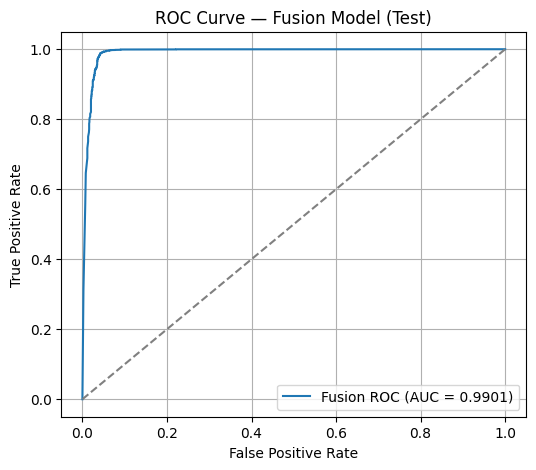

Saved Fusion ROC curve image → /content/drive/MyDrive/Major_Project/IFND_dataset/models_fusion/fusion_roc_curve.png


In [ ]:
# FUSION 11 – ROC Curve for Fusion model

from sklearn.metrics import roc_curve, auc

fpr_f, tpr_f, _ = roc_curve(y_true_f, y_prob_f)
roc_auc_f = auc(fpr_f, tpr_f)

plt.figure(figsize=(6,5))
plt.plot(fpr_f, tpr_f, label=f"Fusion ROC (AUC = {roc_auc_f:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Fusion Model (Test)")
plt.legend(loc="lower right"); plt.grid(True)
fusion_roc_path = os.path.join(SAVE_DIR_FUSION, "fusion_roc_curve.png")
plt.savefig(fusion_roc_path, bbox_inches="tight", dpi=150)
plt.show()
print("Saved Fusion ROC curve image →", fusion_roc_path)


Generating ROC data (Test): 100%|██████████| 165/165 [00:32<00:00,  5.13it/s]


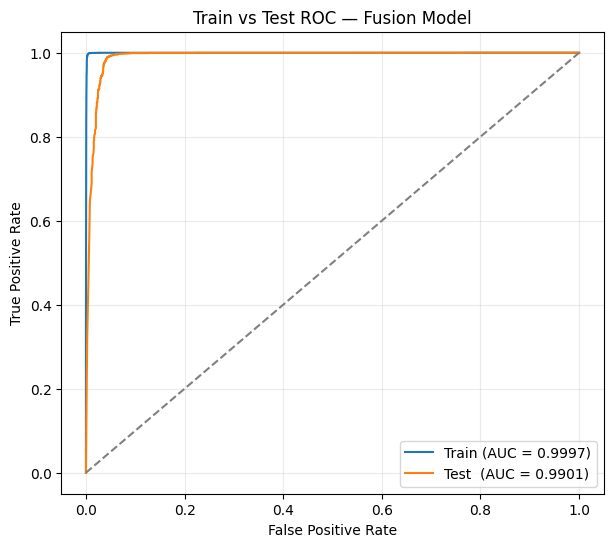

✅ Train AUC: 0.9997
✅ Test  AUC: 0.9901
🎯 Model generalizes well (no overfitting).


In [ ]:
# FUSION 12 – Train vs Test ROC curves
from sklearn.metrics import roc_curve, auc

@torch.no_grad()
def get_roc_data_fusion(dataloader, name="Test"):
    y_true, y_scores = [], []
    for batch in tqdm(dataloader, desc=f"Generating ROC data ({name})"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        hyb_seq = batch["hyb_seq"].to(device)
        labels = batch["labels"].cpu().numpy()

        logits = fusion_model(input_ids, attention_mask, hyb_seq)
        probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()

        y_true.extend(labels)
        y_scores.extend(probs)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

# ⚠️ Ensure best model loaded:
fusion_model.load_state_dict(torch.load(best_fusion_path, map_location=device))
fusion_model.to(device)
fusion_model.eval()

fpr_train_f, tpr_train_f, auc_train_f = get_roc_data_fusion(train_fusion_loader, name="Train")
fpr_test_f,  tpr_test_f,  auc_test_f  = get_roc_data_fusion(test_fusion_loader,  name="Test")

plt.figure(figsize=(7,6))
plt.plot(fpr_train_f, tpr_train_f, label=f"Train (AUC = {auc_train_f:.4f})")
plt.plot(fpr_test_f,  tpr_test_f,  label=f"Test  (AUC = {auc_test_f:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train vs Test ROC — Fusion Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.25)
plt.show()

print(f"✅ Train AUC: {auc_train_f:.4f}")
print(f"✅ Test  AUC: {auc_test_f:.4f}")

if abs(auc_train_f - auc_test_f) <= 0.02:
    print("🎯 Model generalizes well (no overfitting).")
elif abs(auc_train_f - auc_test_f) <= 0.05:
    print("⚠️ Slight overfitting, but acceptable.")
else:
    print("🚨 Significant overfitting detected — check regularization or data balance.")


In [ ]:
# FUSION 13 – Save per-sample predictions

fusion_preds_df = pd.DataFrame({
    "y_true": y_true_f,
    "y_prob_TRUE": y_prob_f,
    "y_pred": y_pred_f
})

fusion_preds_path = os.path.join(SAVE_DIR_FUSION, "fusion_test_predictions.csv")
fusion_preds_df.to_csv(fusion_preds_path, index=False)
print("✅ Saved fusion test predictions →", fusion_preds_path)


✅ Saved fusion test predictions → /content/drive/MyDrive/Major_Project/IFND_dataset/models_fusion/fusion_test_predictions.csv


In [ ]:
import torch
import tensorflow as tf
import transformers
import sklearn
import numpy as np
import pandas as pd

print(f"PyTorch: {torch.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

PyTorch: 2.9.0+cu126
TensorFlow: 2.19.0
Transformers: 4.57.2
Scikit-learn: 1.6.1
NumPy: 2.0.2
Pandas: 2.2.2
